<a href="https://colab.research.google.com/github/TheMathAI/Movie-Recommender-System-ML/blob/main/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import library
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

In [ ]:
!apt install subversion
!svn checkout https://github.com/TheMathAI/ML_Project/trunk/clean_Data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,235 kB of archives.
After this operation, 9,916 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/univer

I'm testing to see how to commit and push to github.

In [ ]:
df_movies = pd.read_csv("/content/clean_Data/df_movies.csv")
df_users = pd.read_csv("/content/clean_Data/df_users.csv")
df_ratings = pd.read_csv("/content/clean_Data/df_ratings.csv")

In [ ]:
# making the rating dataframe with column for column for movies and row for users (kind of a matrix)
df_ratings_pivot = df_ratings.pivot(index = 'userID', columns ='movieID', values = 'rating').fillna(0)
display(df_ratings_pivot)

movieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Try to implement cross-valdiation, so divide matrix in 4 and mask 3/4 which is goig to be the test matrix

In [ ]:
# fill empty values with nan
df_ratings_pivot_nan = df_ratings.pivot(index = 'userID', columns ='movieID', values = 'rating')

In [ ]:
# turn the dataframe into a numpy array (matrix)
ratings_array_nan = df_ratings_pivot_nan.values
# will use this matrix in last step to verify predictions make the null_mask that will be use for k cross-validation
null_mask = np.isnan(ratings_array_nan)
null_mask = np.invert(null_mask)
# turning the dataframe into a numpy array for calculations // here it is the dataframe without nan but zeroes instead
df_ratings_array = df_ratings_pivot.values

Function that creates the folds for the k-cross validation

In [ ]:
def cv_matrices(X, fold):
    """
    Given a matrix X, the function creates 4 sets of train + test matrices
    where each train matrix is masked with zeros in 0.25 of the values, and the
    test matrix is masked zeros in 0.75 of them.
    X - numpy array
    fold - is an integer from 0-3.
    Returns the masked data and also the masks for train and test
    """
    # Create a dict with the which store the indexes where we slices the matrix
    rows = X.shape[0]
    cols = X.shape[1]
    mid_rows = int(rows/2)
    mid_cols = int(cols/2)
    
    idx_dict = {
                0: [[0,mid_rows],[0, mid_cols]],
                1: [[0,mid_rows],[mid_cols, cols]],
                2: [[mid_rows, rows], [0, mid_cols]],
                3: [[mid_rows, rows], [mid_cols, cols]]
    }
    
    idexes = idx_dict[fold]
    # Create the different mask of train and test
    train_mask = np.full((rows, cols), 1)
    train_mask[idexes[0][0]:idexes[0][1], idexes[1][0]:idexes[1][1]] = 0
    test_mask = 1 - train_mask
    
    
    # Create X_train
    X_train = X.copy()
    X_train[train_mask==0] = 0
    
    # Create X_test
    X_test = X.copy()
    X_test[train_mask==1] = 0
        
    return X_train, X_test, train_mask, test_mask

In [ ]:
# here it would the loop of the k-fold validation
store_folds = {}
for i in range(1, 200):
  sum = 0
  for j in range(4):
    
    X_train, X_test, train_mask, test_mask = cv_matrices(df_ratings_array,j)
    train_null_mask = null_mask * train_mask
    test_null_mask = null_mask * test_mask
    # calculating the mean for each users
    mean_users_ratings = np.mean(X_train, axis = 1)

    # demeaning the the array, so that each observations are mean zero
    df_demean = X_train - mean_users_ratings.reshape(-1, 1)

    # singular value decomposition of the matrix, to turn the matrix into a singular vector with singular values
    U, s, Vh = svds(df_demean, k = i)

    # diagonalize matrix
    s = np.diag(s)

    # get the user predicting ratings for movies and then add the mean back to get right ratings
    predicted_ratings = np.dot(np.dot(U, s), Vh) + mean_users_ratings.reshape(-1, 1)

    # keeps only the ratings of the test fold
    predicted_ratings_mask = np.multiply(predicted_ratings, test_null_mask)
    predicted_ratings_mask_square = np.square(predicted_ratings_mask)
    sum += predicted_ratings_mask_square.sum()

  store_folds[i] = sum

 

In [ ]:
 min(store_folds, key=store_folds.get)

3

In [ ]:
import csv
with open('latent_feature_data.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=store_folds.keys())
    writer.writeheader()
    writer.writerow(store_folds)

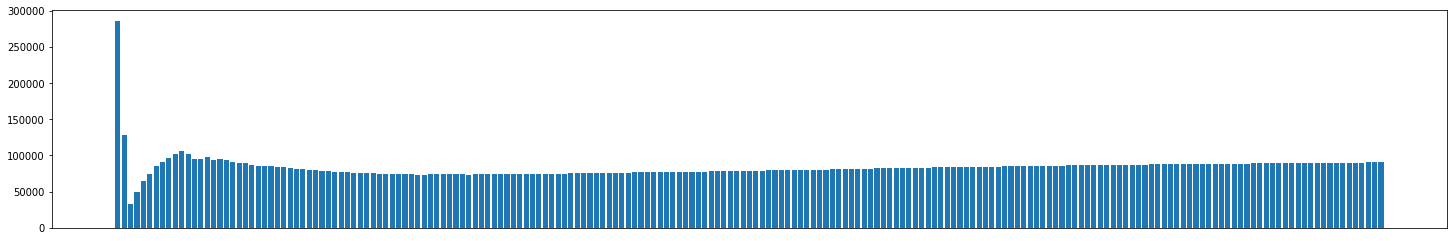

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(25)
plt.bar(range(len(store_folds)), list(store_folds.values()), align='center')
plt.xticks(range(len(store_folds)), list(store_folds.keys()))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.savefig('bar_latent_featureL.png')
plt.show()

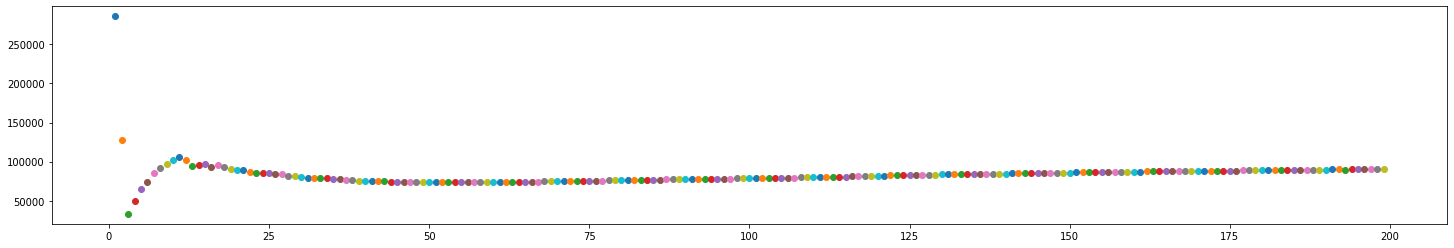

In [ ]:
colors = list("rgbcmyk")
r = plt.figure()
r.set_figwidth(25)

for key in store_folds:

    plt.scatter([key], store_folds[key], label=key)

plt.savefig('scatter_latent_featureL.png')
plt.show()



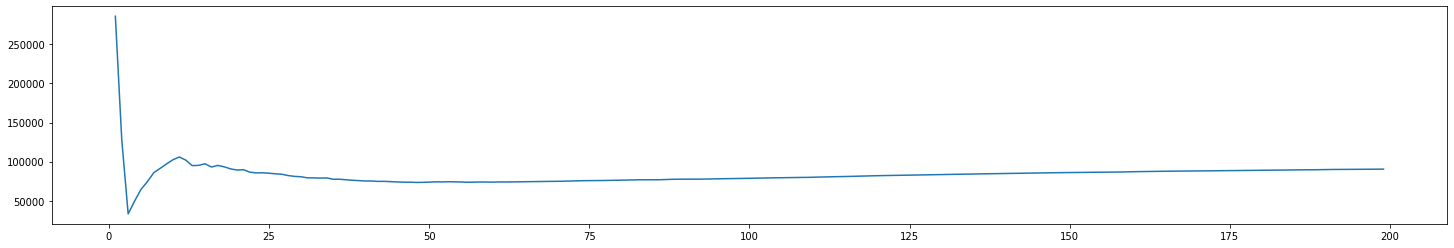

In [ ]:
colors = list("rgbcmyk")
r = plt.figure()
r.set_figwidth(25)
plt.plot(list(store_folds.keys()),list(store_folds.values()))


plt.savefig('plot_latent_featureL.png')
plt.show()


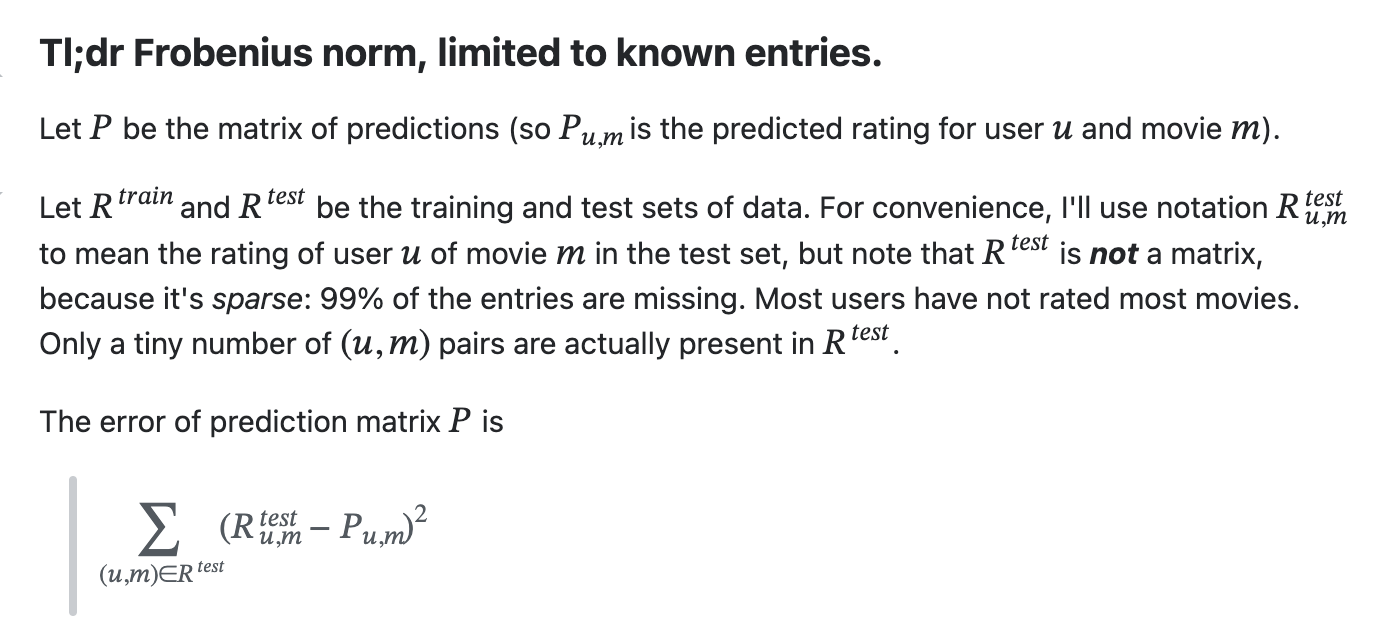

In [ ]:
# turn the predicted ratings into data frame
df_predictions = pd.DataFrame(predicted_ratings, columns = df_ratings_pivot.columns)


In [ ]:
def recommend_movies(df_predictions, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 
    sorted_user_predictions = df_predictions.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieID', right_on = 'movieID').
                     sort_values(['rating'], ascending=False)
                 )

    print(f'User {userID} has rated {user_full.shape[0]} movies.')
    print(f'Recommending the highest {num_recommendations} predicted ratings movies not already rated.')
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (df_movies[~df_movies['movieID'].isin(user_full['movieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieID',
               right_on = 'movieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

user_ratings, user_predictions = recommend_movies(df_predictions, 837, df_movies, df_ratings, 10)

User 837 has rated 69 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [ ]:
user_predictions


,movieID,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1235,1284,"Big Sleep, The (1946)",0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1848,1953,"French Connection, The (1971)",1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
897,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
905,930,Notorious (1946),0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1807,1912,Out of Sight (1998),1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3207,3334,Key Largo (1948),0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0
925,951,His Girl Friday (1940),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2085,2194,"Untouchables, The (1987)",1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1916,2023,"Godfather: Part III, The (1990)",1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1849,1954,Rocky (1976),1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
